# 0.0 IMPORTS

In [101]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt

import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from IPython.core.display import HTML

from boruta                  import BorutaPy
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders       import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper functions

In [11]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [12]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading dataset

In [13]:
data_raw = pd.read_csv('../data/raw/train.csv')

In [14]:
data_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 ANÁLISE DESCRITIVA

In [15]:
df1 = data_raw.copy()

In [16]:
# columns in snakecase
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data informations

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Análise Descritiva

In [18]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.2.1 Atributos Numéricos

In [19]:
# Tendência Central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

In [21]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year')
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 FILTRAGEM DOS DADOS

In [22]:
df3 = df2.copy()

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [23]:
df4 = df3.copy()

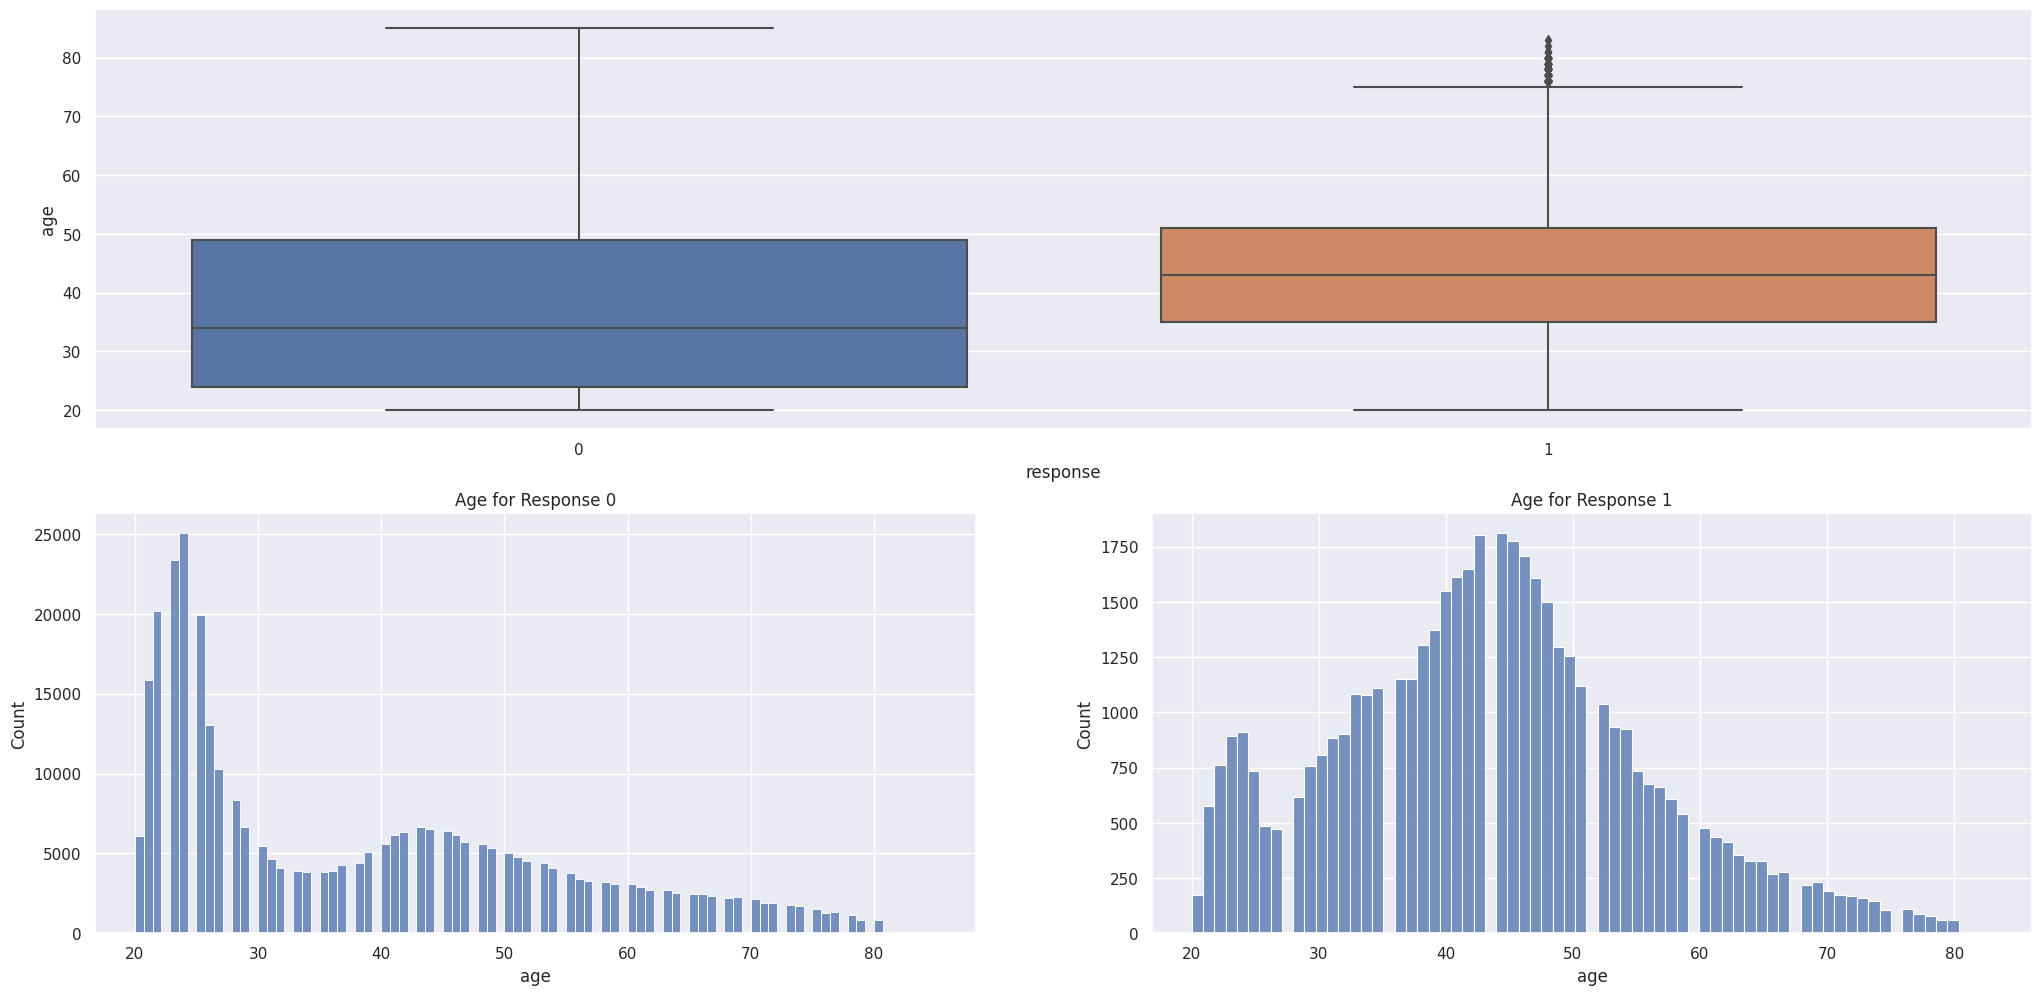

In [24]:
# 'age'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='age', data=df4, ax=ax1)

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='age', ax=ax2)
plt.title('Age for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='age', ax=ax3)
plt.title('Age for Response 1');

gender,Female,Male
response,,
0,0.469006,0.530994
1,0.389317,0.610683


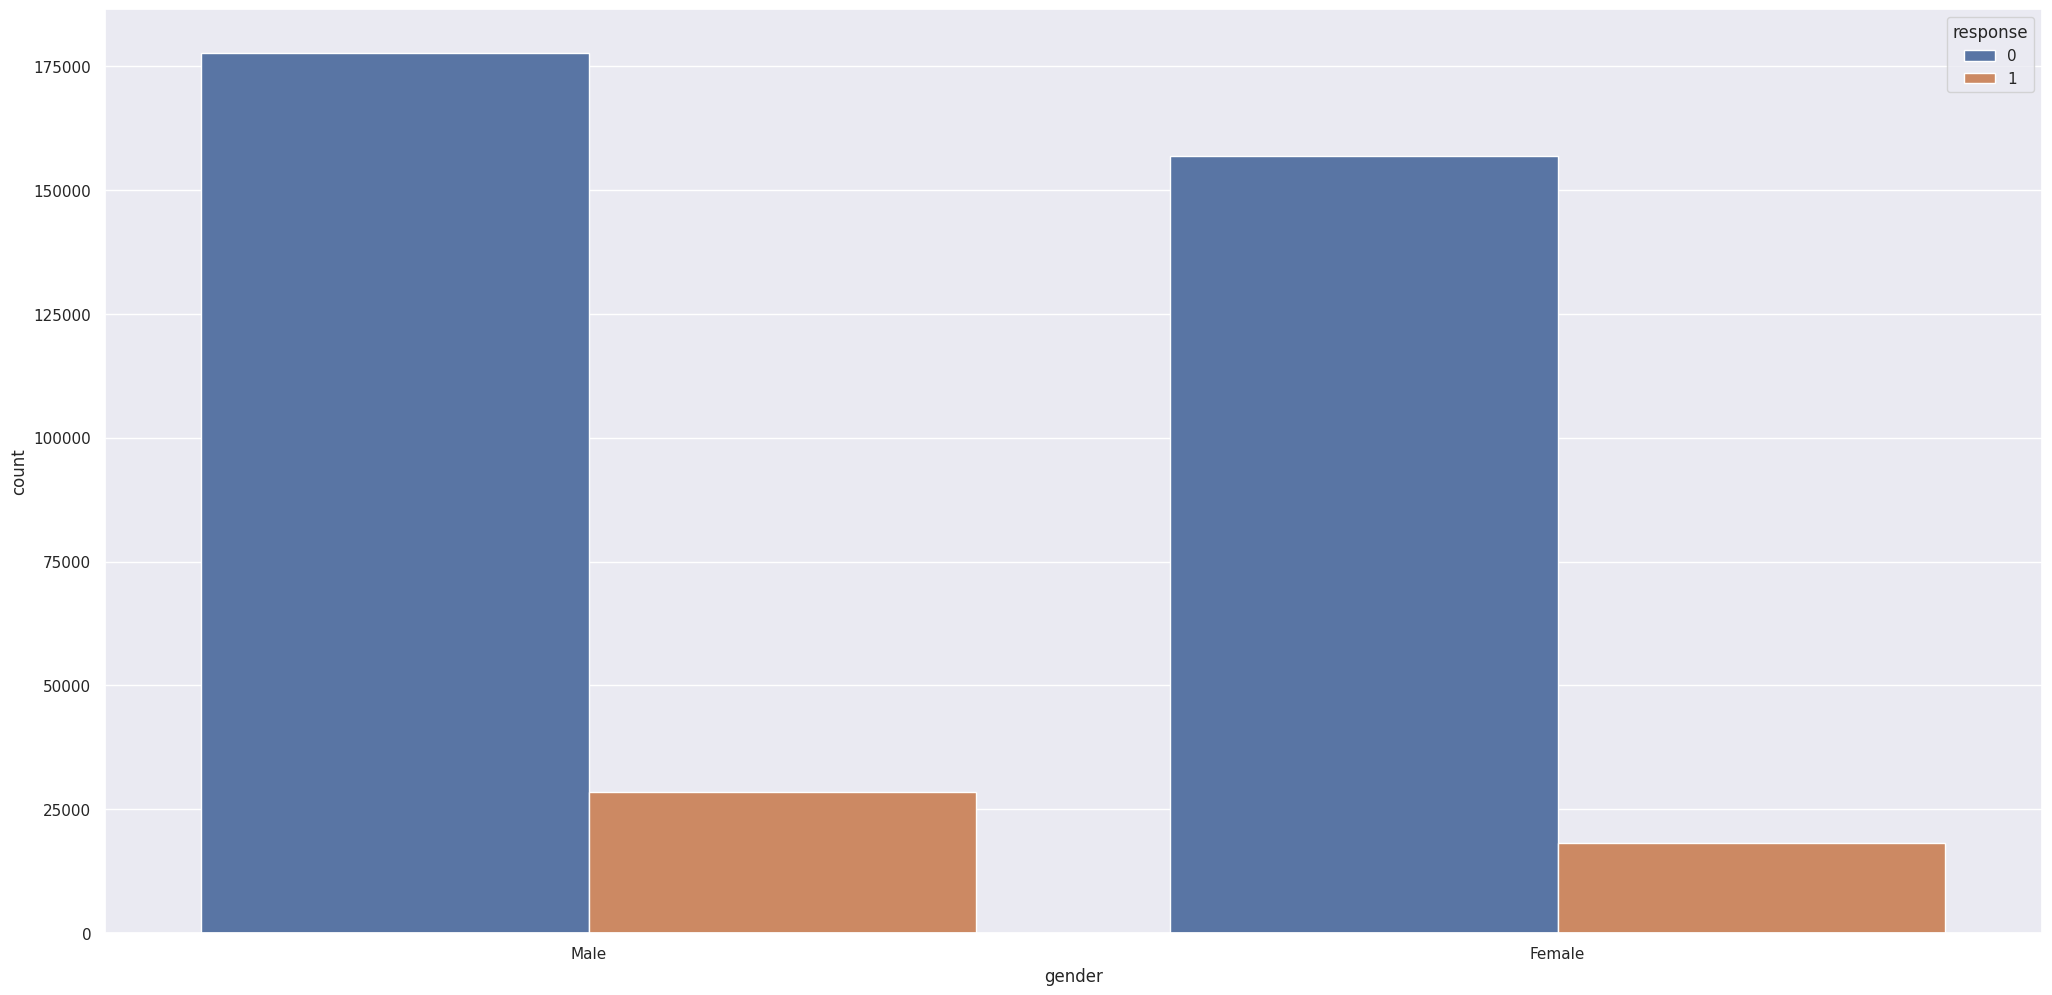

In [25]:
# 'gender'
sns.countplot(x=df4['gender'], hue=df4['response'])

pd.crosstab(df4['response'], df4['gender']).apply(lambda x: x/x.sum(), axis=1)

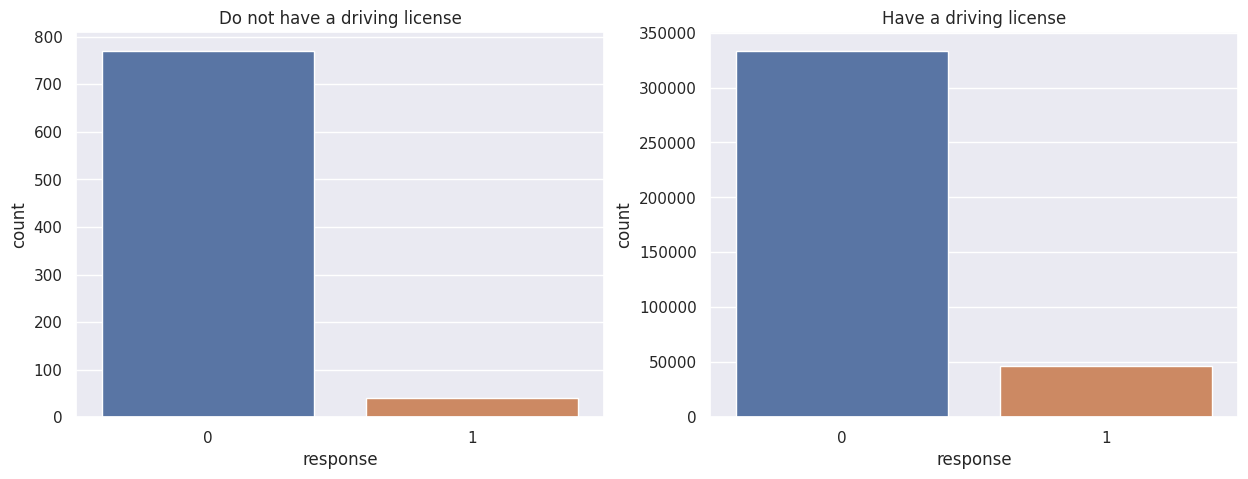

In [26]:
# 'driving_license'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['driving_license'] == 0], ax=ax1)
plt.title('Do not have a driving license')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['driving_license'] == 1], ax=ax2)
plt.title('Have a driving license');

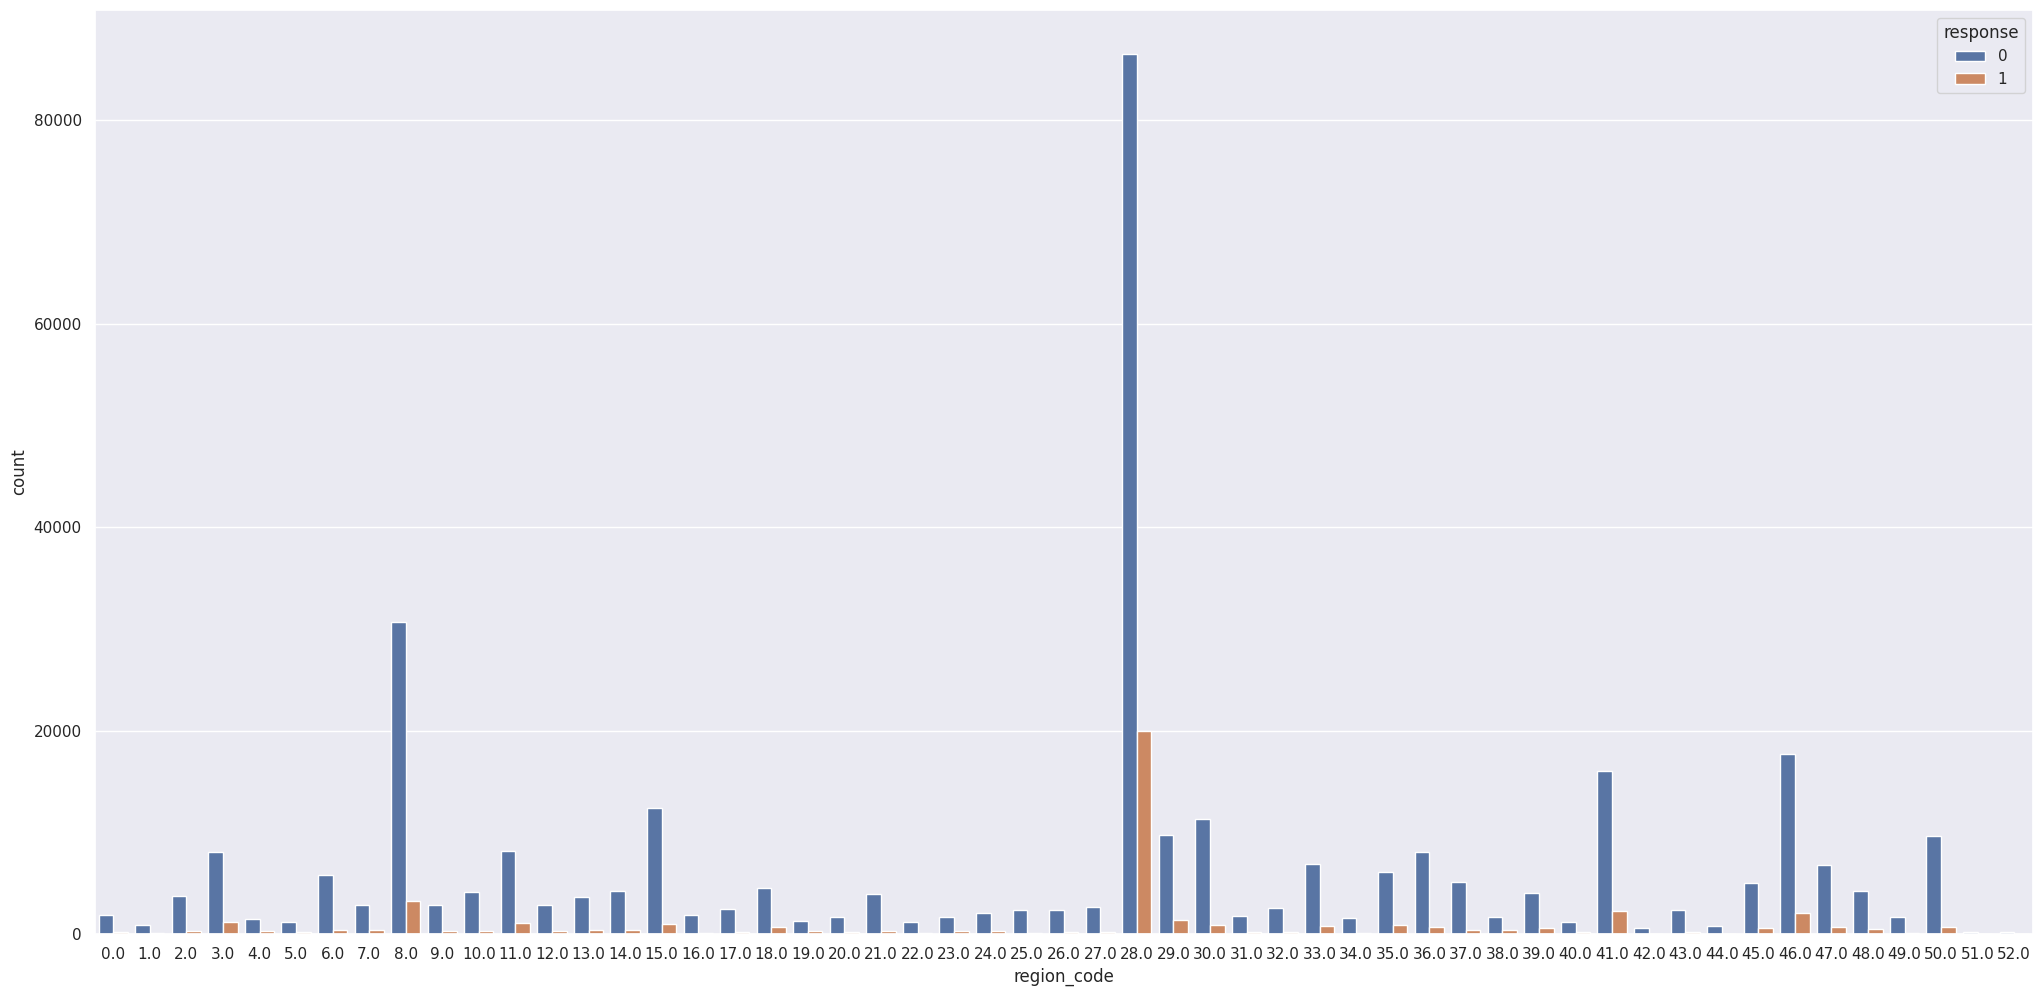

In [27]:
# 'region_code'
sns.countplot(x='region_code', hue='response', data=df4);

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


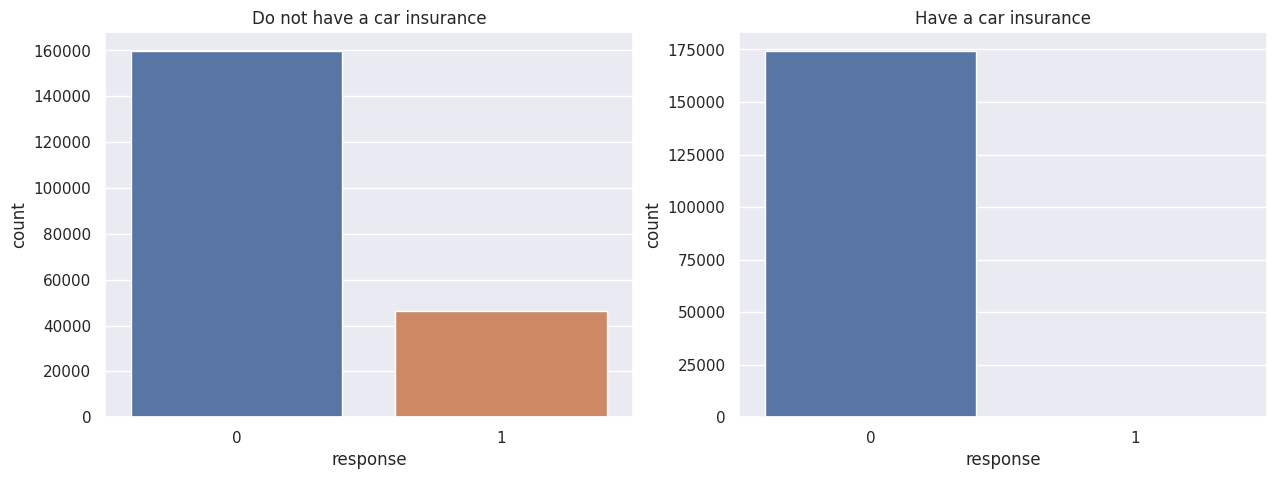

In [28]:
# 'previously_insured'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 0], ax=ax1)
plt.title('Do not have a car insurance')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 1], ax=ax2)
plt.title('Have a car insurance');

# percentage
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

In [29]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


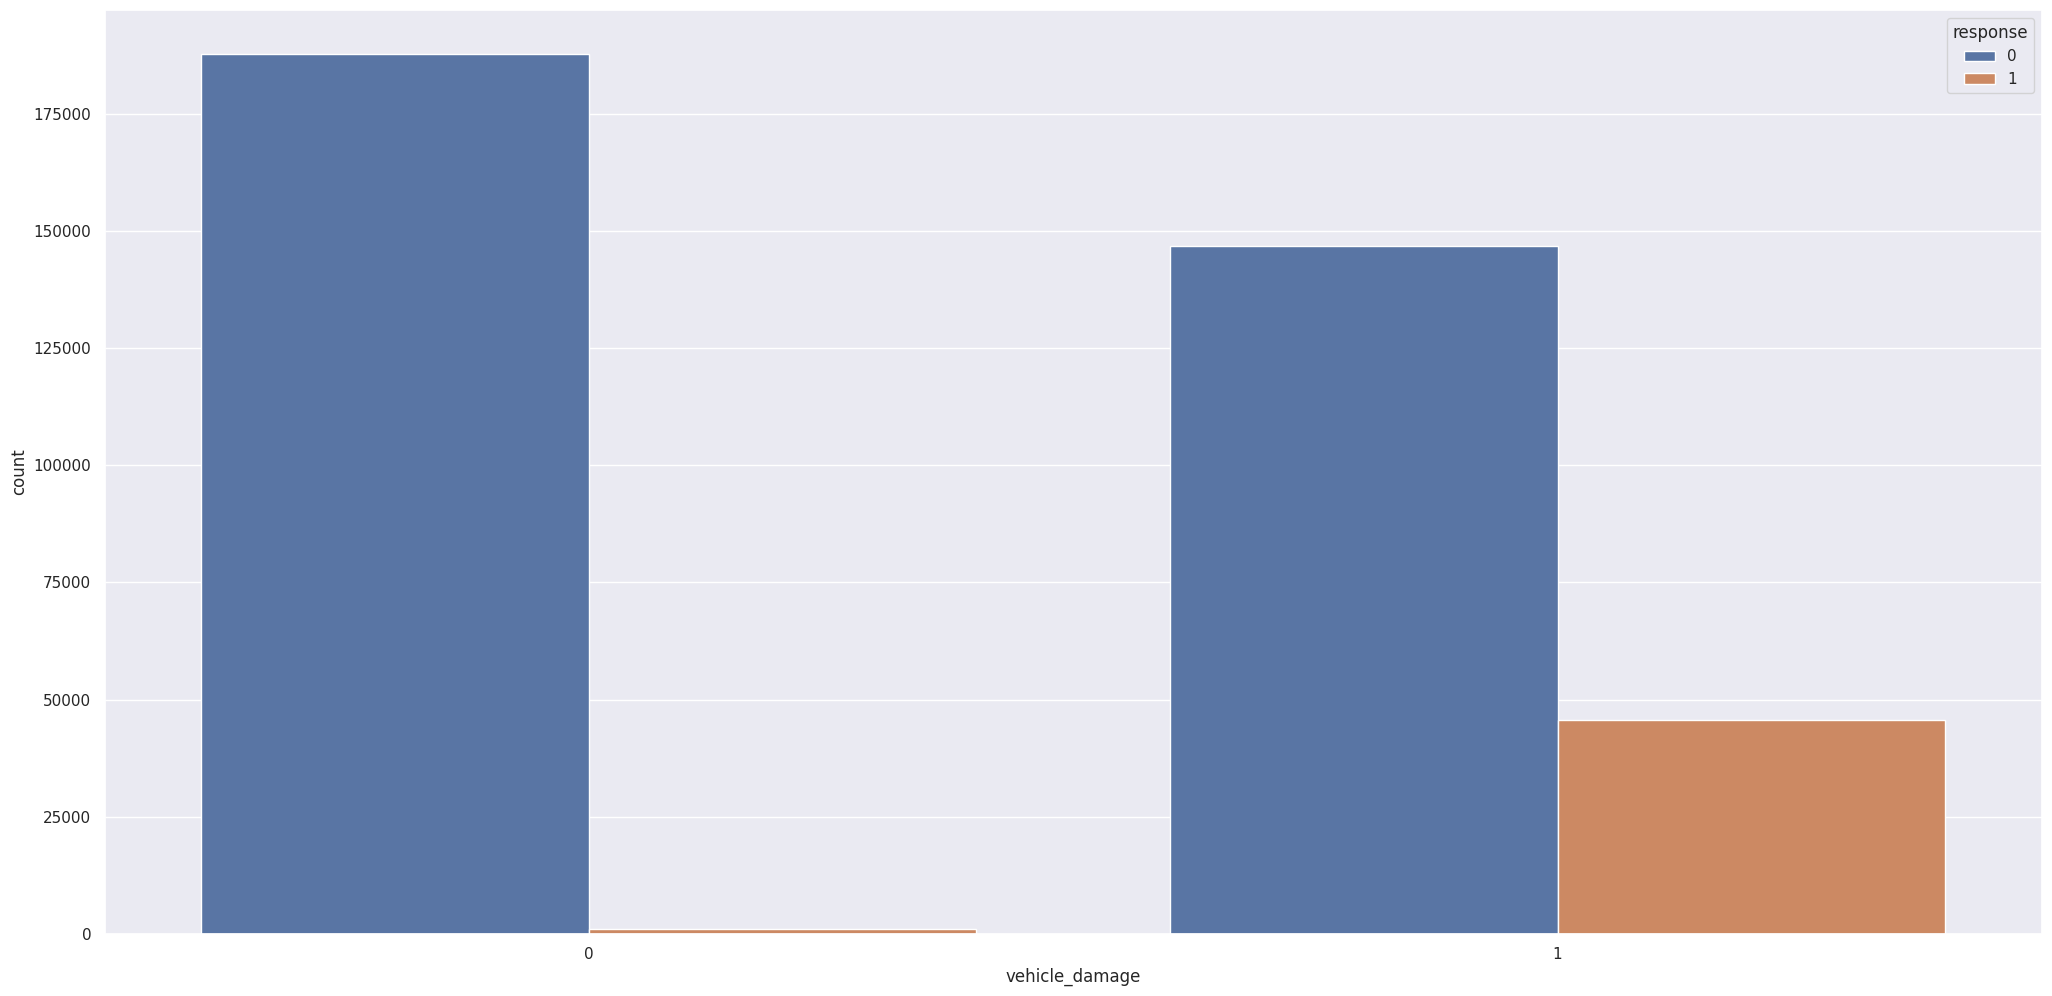

In [30]:
# 'vehicle_damage'
sns.countplot(x=df4['vehicle_damage'], hue=df4['response'])

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

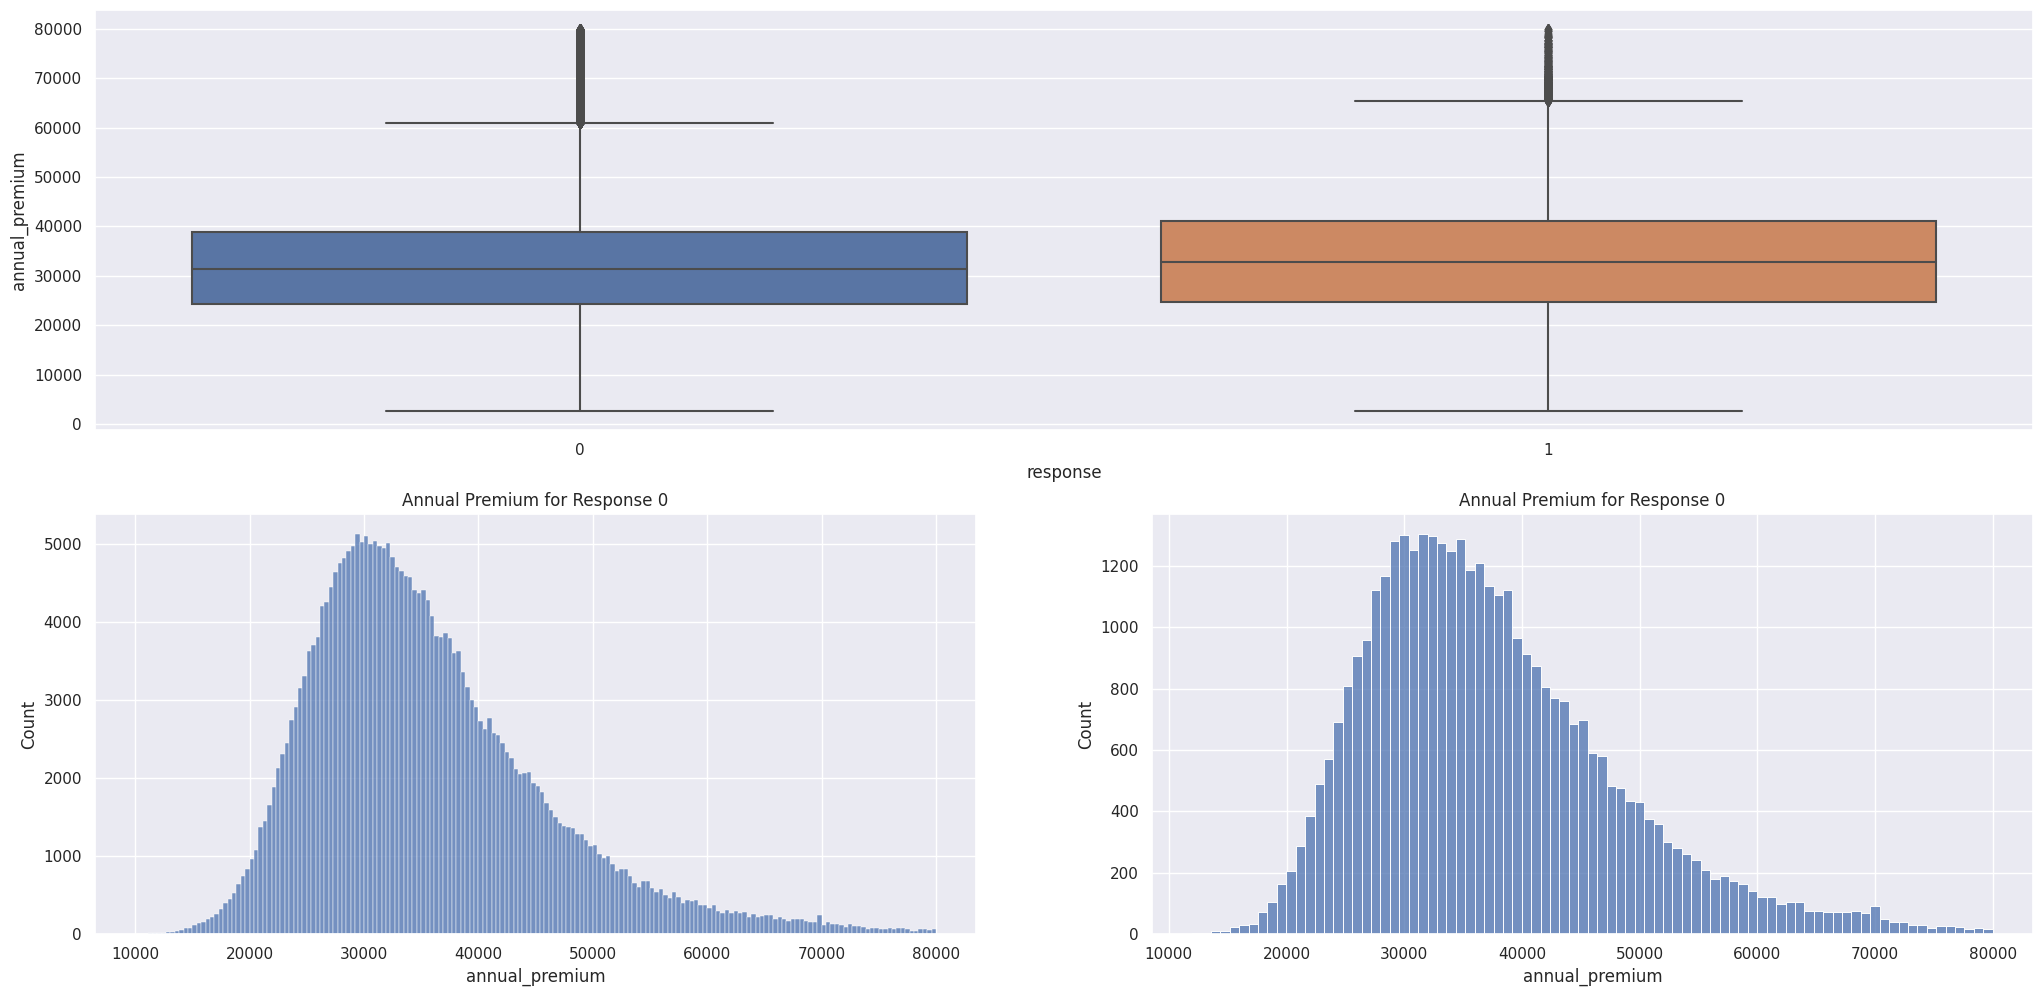

In [31]:
# 'annual_premium'
G = gridspec.GridSpec(2, 2)

aux = df4[df4['annual_premium'] < 80000]
ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='annual_premium', data=aux, ax=ax1)

# Removing outliers for better visualization
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=aux2[aux2['response'] == 0], x='annual_premium', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=aux2[aux2['response'] == 1], x='annual_premium', ax=ax3)
plt.title('Annual Premium for Response 0');

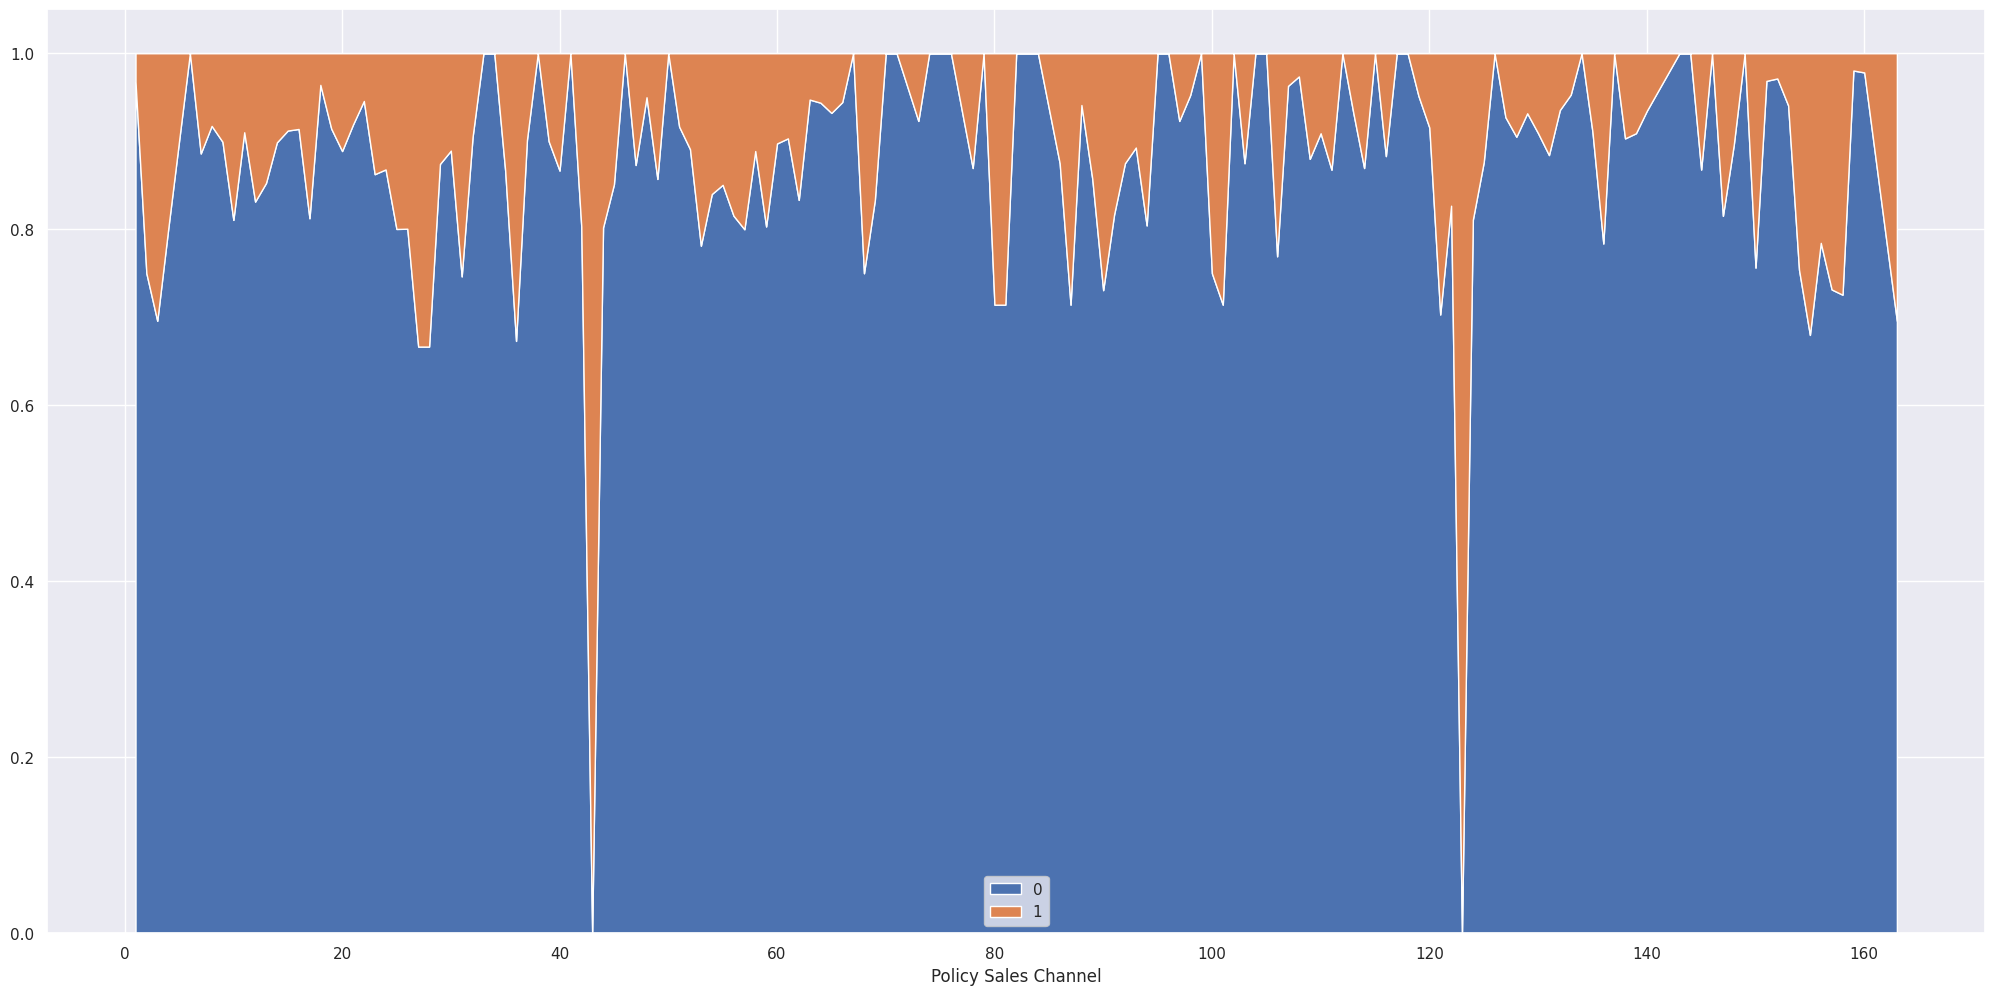

In [32]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

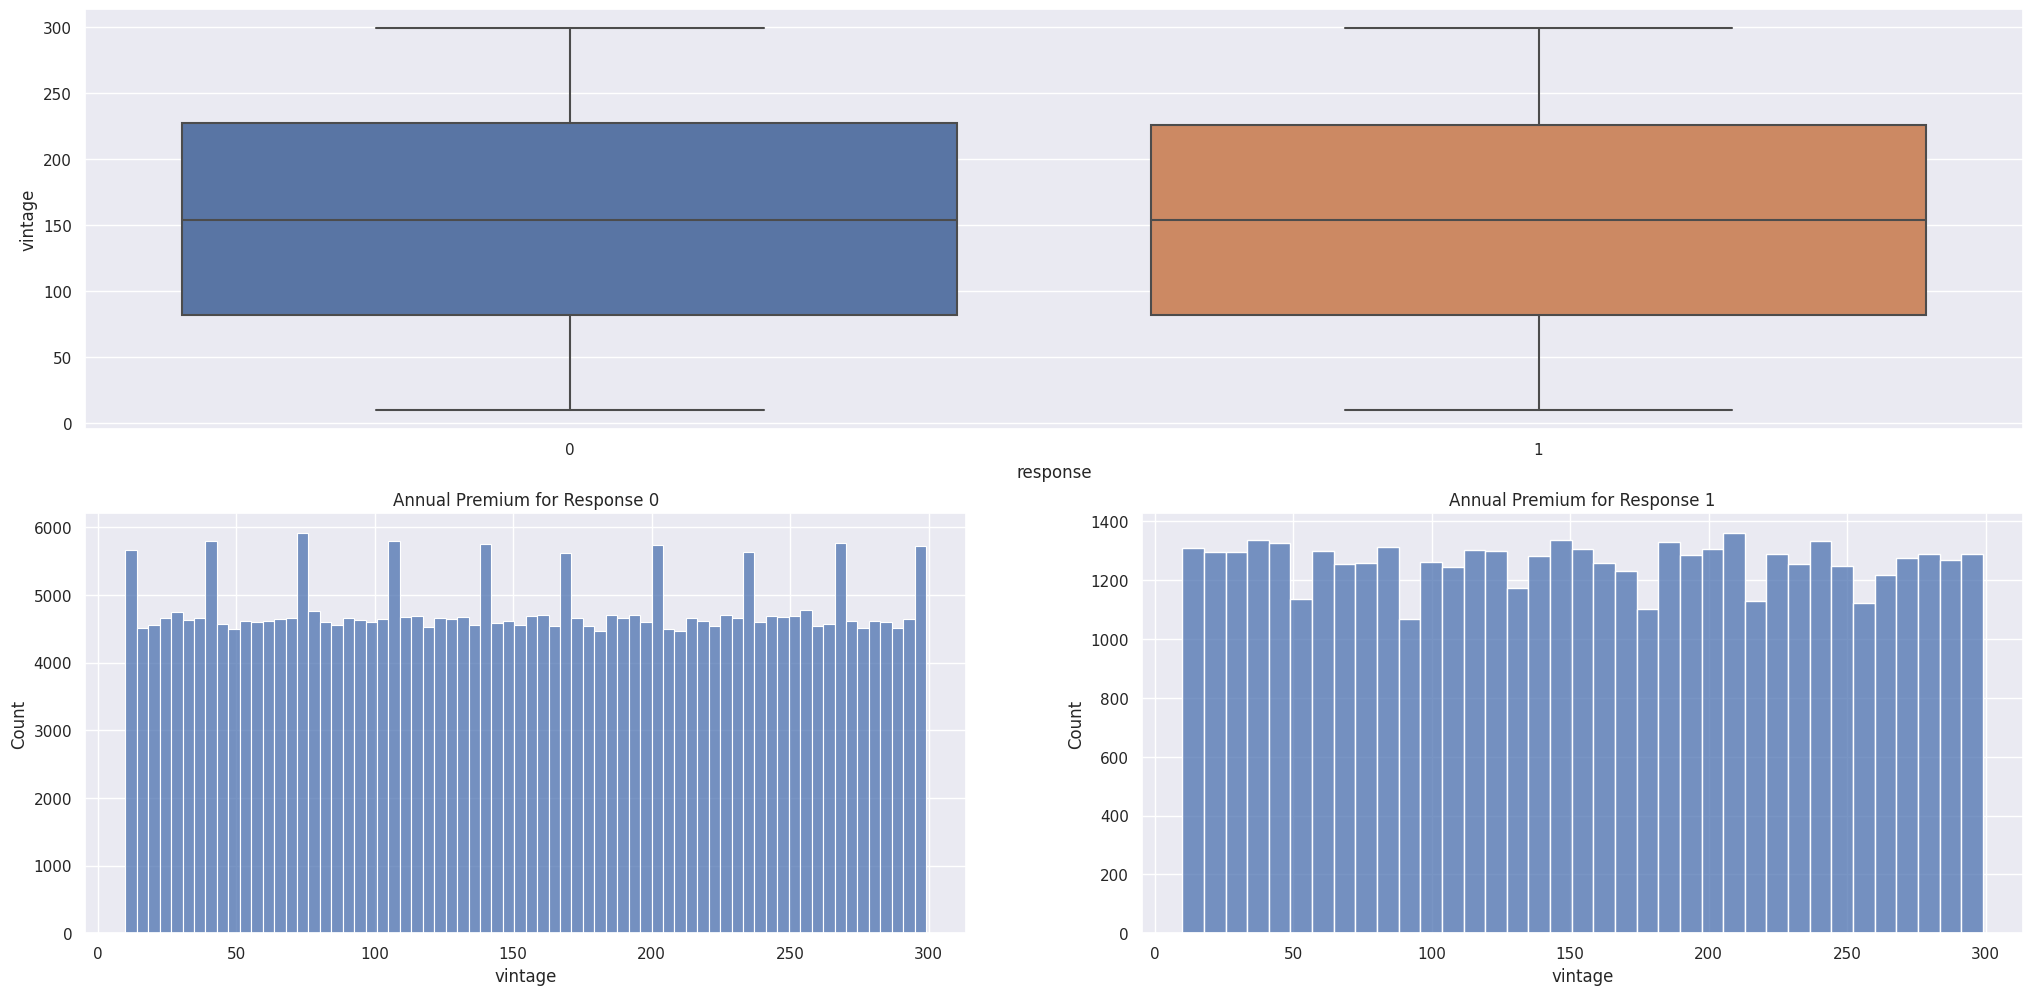

In [33]:
# 'vintage'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x=df4['response'], y=df4['vintage'])

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='vintage', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='vintage', ax=ax3)
plt.title('Annual Premium for Response 1');

# 5.0 DATA PREPARATION

## 5.1 Data Split 

In [82]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=50)

## Standardization

In [83]:
ss = StandardScaler()

# annual_premium
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)

## Rescaling

In [84]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age (since its distribution is not a normal one)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)

## Encoder

In [85]:
# gender
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])


# region_code - Target Enconder
te = TargetEncoder()
X_train['region_code'] = X_train['region_code'].astype(str)
X_train['region_code'] = te.fit_transform(X_train['region_code'], y_train)


# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_train['vehicle_age'] = X_train['vehicle_age'].map(vehicle_age_dict)


# policy_sales_channel - Frequency Encoding
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].astype(str)
cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
X_train = cfe.fit_transform(X_train)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## Validation Encoding

In [86]:
# annual_premium
X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# age (since its distribution is not a normal one)
X_val['age'] = mms_age.transform(X_val[['age']].values)

# vintage
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# gender
X_val['gender'] = le.transform(X_val['gender'])

# region_code - Target Enconder
X_val['region_code'] = X_val['region_code'].astype(str)
X_val['region_code'] = te.transform(X_val['region_code'])

# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_val['vehicle_age'] = X_val['vehicle_age'].map(vehicle_age_dict)

# policy_sales_channel - Frequency Encoding
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].astype(str)
X_val = cfe.transform(X_val)
X_val = X_val.replace(np.nan, 0)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(


# 6.0 FEATURE SELECTION

## 6.1 Boruta Selection

In [34]:
# training and test dataset for Boruta
X_train_b = X_train.drop(['id', 'region_code'], axis=1).values
y_train_b = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration:

In [36]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['id', 'region_code'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [42]:
print(f'Cols selected:{cols_selected_boruta}')
print(f'Cols not selected: {cols_not_selected_boruta}')

Cols selected:['vehicle_damage']
Cols not selected: ['age' 'annual_premium' 'driving_license' 'gender' 'policy_sales_channel'
 'previously_insured' 'region_code_encoded' 'vehicle_age' 'vintage']


## 6.2 Features Importance

In [45]:
# Model
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

# data preparation
X_train_n = X_train.drop(['id', 'region_code'], axis=1)
y_train_n = y_train.values

forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

In [46]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                feature  importance
0               vintage    0.278095
0        annual_premium    0.246704
0                   age    0.157871
0   region_code_encoded    0.105943
0        vehicle_damage    0.071834
0  policy_sales_channel    0.060828
0    previously_insured    0.056785
0           vehicle_age    0.016155
0                gender    0.005294
0       driving_license    0.000489


In [91]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

# 7.0 MACHINE LEARNING

In [92]:
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]

## K-Nearest Neighbors

In [99]:
# Model
knn_model = KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

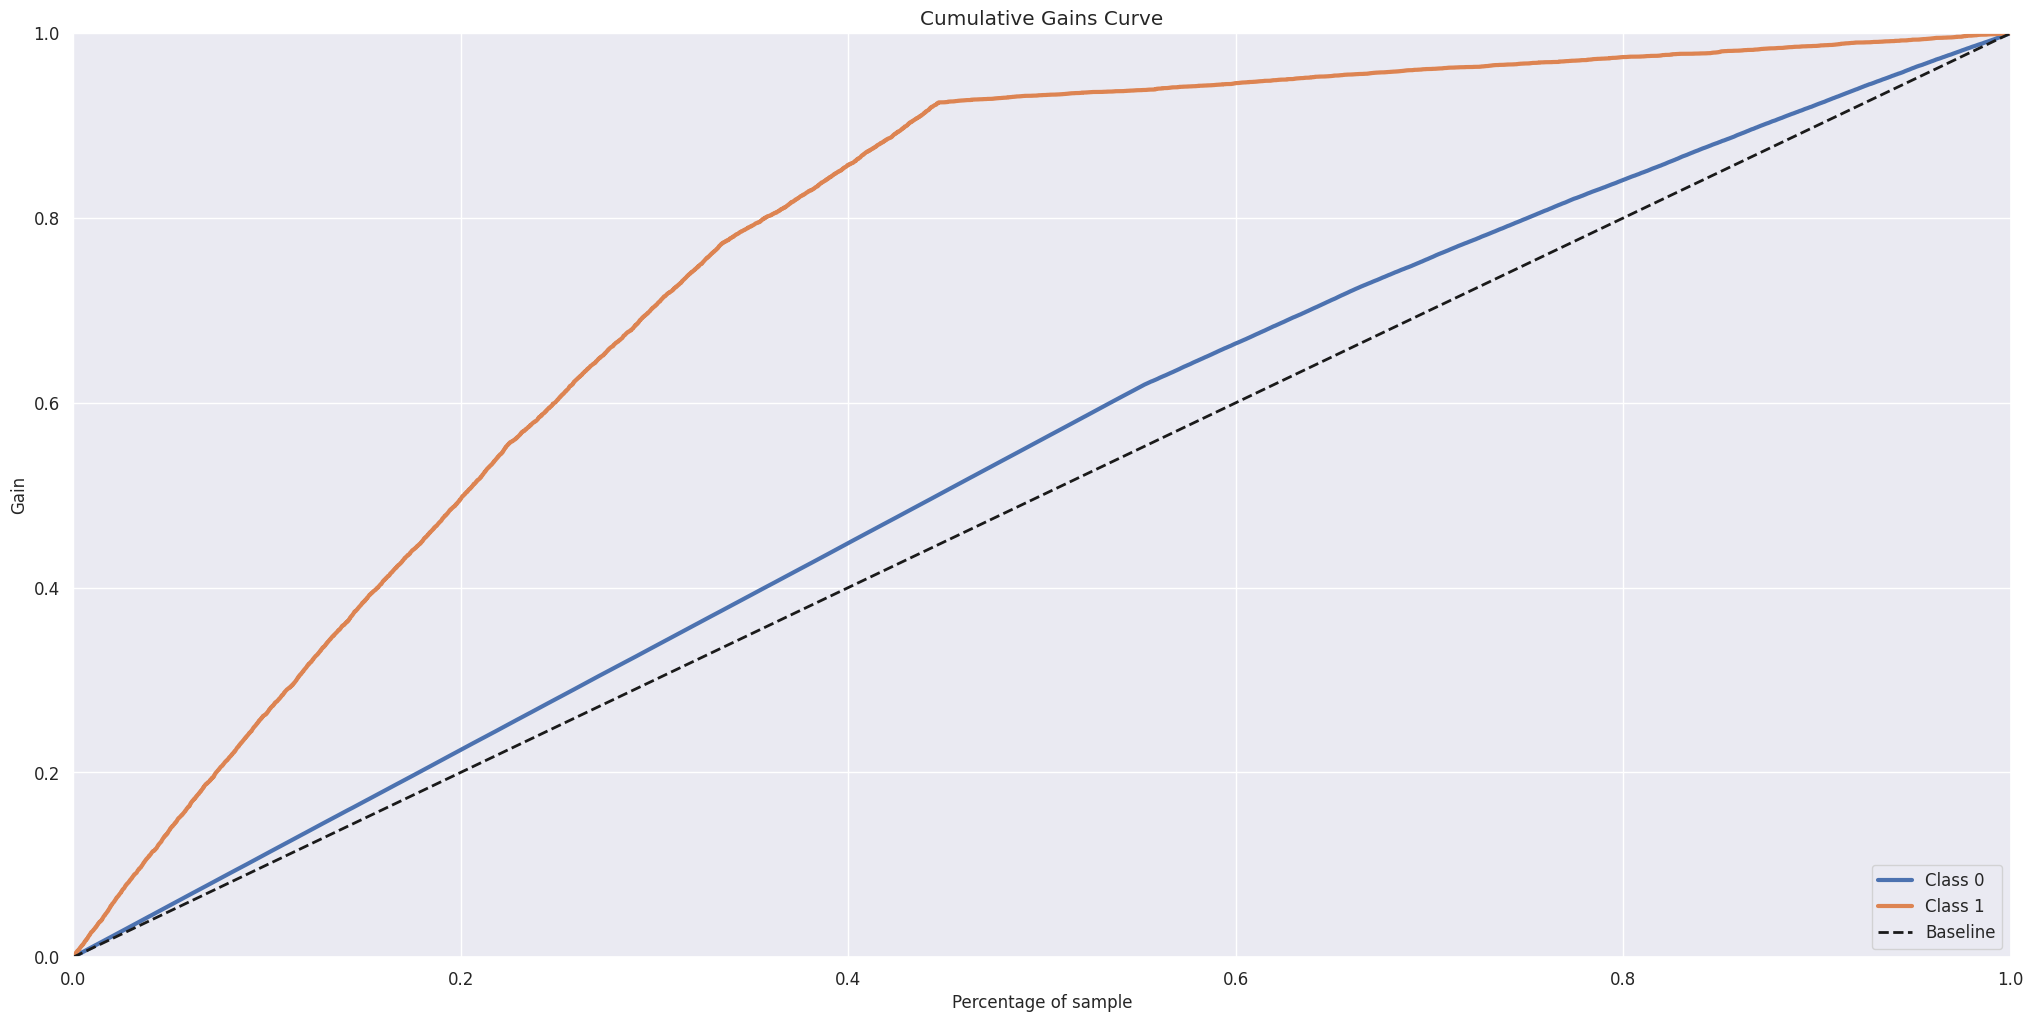

In [100]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

## Logistic Regression

In [97]:
# Model
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

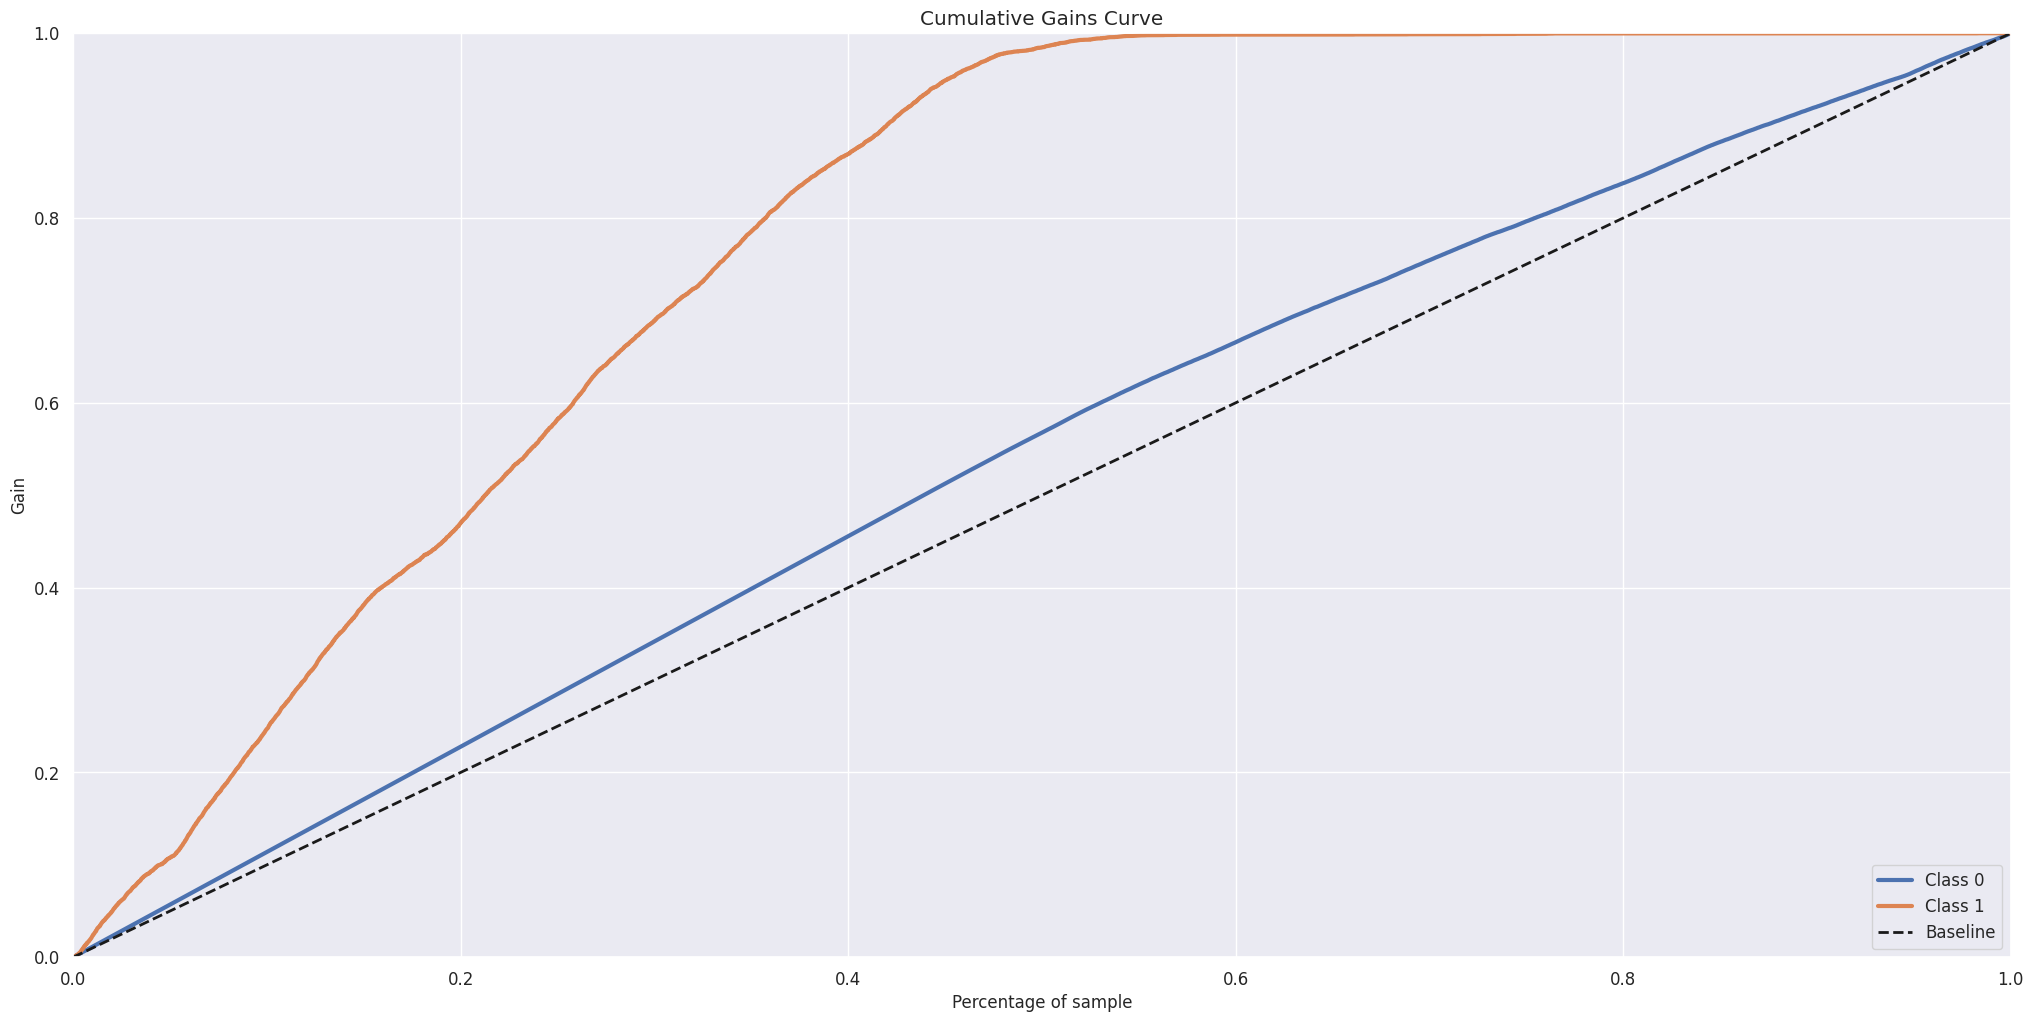

In [98]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

## Random Forest

In [104]:
# Model
rf_model = RandomForestClassifier()

# model training
rf_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_rf = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

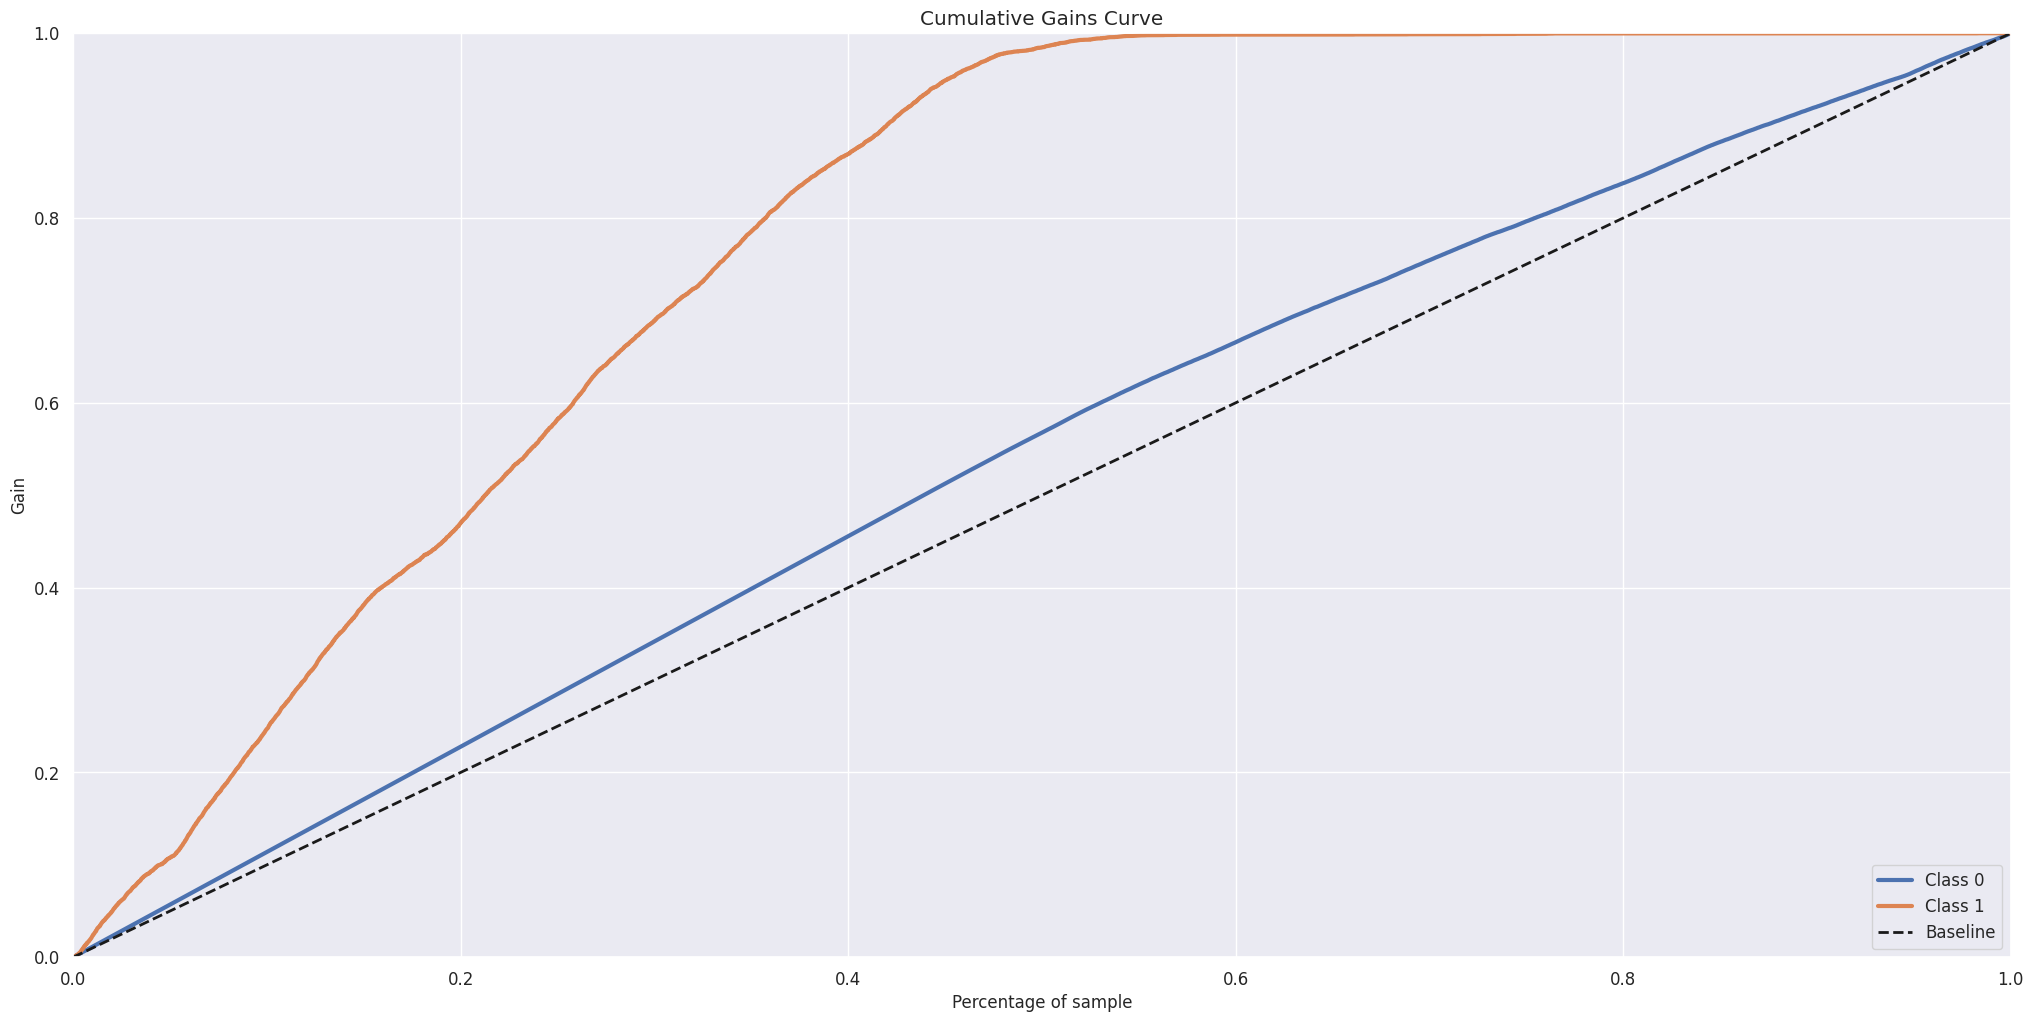

In [105]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)